In [1]:
%run _startup.ipynb

In [2]:
import requests
from lxml import etree
from lxml.html import fromstring, tostring
from bs4 import BeautifulSoup

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# Function to get FRED data
def get_fred(id1):
    params = {
        'file_type': 'json',
        'api_key': os.getenv('FRED_API_KEY'),
        'series_id': id1,
        # 'observation_start': '2023-12-02',
        # 'observation_end': '2024-12-02',
    }
    pre = 'series/observations?'  # series/observations series
    post = '&'.join([f'{k}={v}' for k,v in params.items()])
    url = f'https://api.stlouisfed.org/fred/{pre}{post}'
    resp = requests.get(url)
    df = pd.DataFrame(json.loads(resp.text)['observations'])
    return df[['date','value']] 

### 1. Collect Federal Funds Target Rates

In [5]:
# get data
df1 = get_fred('DFEDTAR')
df2 = get_fred('DFEDTARU')

# merge
df = pd.concat([df1,df2]).rename(columns = {'value': 'DFEDTAR'})
feat1 = 'DFEDTAR'
df[feat1] = df[feat1].astype(float)
df[f'{feat1}_diff'] = df[feat1].diff()
df['dt1'] = pd.to_datetime(df['date'])
df['dt_month'] = pd.to_datetime(df['dt1'].astype(str).str[:7])

# took only rows where rate changes 
f1 = df[f'{feat1}_diff'] != 0
df = df[f1].groupby(['dt_month']).agg({
    'dt1': lambda x: x.iloc[-1],
    'DFEDTAR': lambda x: x.iloc[-1],
    'DFEDTAR_diff': [sum, len]
})
df.columns = ['dt1','DFEDTAR','DFEDTAR_diff','cnt_change']
df.reset_index(inplace = True)

df.to_pickle('data/df_target.pkl')

print(df.shape)
df[:3]

(155, 5)


,dt_month,dt1,DFEDTAR,DFEDTAR_diff,cnt_change
0,1982-09-01,1982-09-27,10.25,0.00,1
1,1982-10-01,1982-10-07,9.50,-0.75,2
2,1982-11-01,1982-11-19,9.00,-0.50,1


### 2. Get main indicators

In [6]:
dict_feats = {
 'Economic Activity': 'GDP GDPC1 EXPGS PNFI INDPRO CFNAI',
 'Financial Conditions': 'TOTBKCR DPSACBW027SBOG STLFSI4 NFCI',
 'Inflation': 'CPILFESL CPIAUCSL PCE PCEPI PCEPILFE MICH',
 'Labor Market Conditions': 'PAYEMS UNRATE EMRATIO',
 'Monetary Policy Actions': 'WSECOUT'
}

dict_reg = {
 'Lag monthly': 'INDPRO CFNAI PCE PCEPI PCEPILFE MICH',
 'Monthly': 'CPILFESL CPIAUCSL PAYEMS UNRATE EMRATIO',
 'Quarterly': 'GDP GDPC1 EXPGS PNFI',
 'Weekly': 'TOTBKCR DPSACBW027SBOG STLFSI4 NFCI WSECOUT'
}

dict_post = {
 'Percent change 12': 'GDP GDPC1 EXPGS PNFI TOTBKCR DPSACBW027SBOG CPILFESL CPIAUCSL PCE PCEPI PCEPILFE PAYEMS WSECOUT'    
}

In [12]:
# create initial dataframe with dates
df = get_fred('UNRATE')
df['dt1'] = pd.to_datetime(df['date'])
del df['date']
del df['value']
df = df[df.dt1 > '1980-01-01'].reset_index(drop = True)
print(df.shape)
df[:3] 

(538, 1)


,dt1
0,1980-02-01
1,1980-03-01
2,1980-04-01


In [13]:
# parse all indexes
for k,v in tqdm(dict_feats.items()):
    list_ids = v.split(' ')
    for i,id1 in enumerate(list_ids):
        try:
            df1 = get_fred(id1)
            
            # value conversion
            df1 = df1[df1['value'] != '.'].rename(columns = {'value': id1})
            df1[id1] = df1[id1].astype(float)
            
            # dates for weekly data
            if id1 in dict_reg['Weekly'].split(' '):
                df1['dt1'] = pd.to_datetime(df1['date'].astype(str).str[:7])
                df1 = df1.groupby('dt1')[id1].mean().reset_index()
            
            # for monthly and quarterly
            else:
                df1['dt1'] = pd.to_datetime(df1['date'])
                del df1['date']

            # for quarterly we need to use shift of 3 month
            if id1 in dict_reg['Quarterly'].split(' '):
                df1['dt1'] = df1['dt1'].map(lambda x: x + relativedelta(months = 3))
                
            # for monthly with lag wee need to shift 1 months since we still don't have fresh data
            if id1 in dict_reg['Lag monthly'].split(' '):
                df1['dt1'] = df1['dt1'].map(lambda x: x + relativedelta(months = 1))
            
            # merge with previous data
            df = df.merge(df1, how = 'left')
            
            time.sleep(5)
        except Exception as e:
            print(id1, e)

for feat in list_quarterly.split(' '):
    df[feat] = df[feat].ffill()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:00<00:00, 24.09s/it]


In [14]:
# check data
print(df.shape)
df[-5:]

(538, 21)


,dt1,GDP,GDPC1,EXPGS,PNFI,INDPRO,CFNAI,TOTBKCR,DPSACBW027SBOG,STLFSI4,NFCI,CPILFESL,CPIAUCSL,PCE,PCEPI,PCEPILFE,MICH,PAYEMS,UNRATE,EMRATIO,WSECOUT
533,2024-07-01,"29,016.71","23,223.91","3,154.32","4,018.47",103.28,-0.12,"17,724.77","17,601.05",-0.74,-0.51,318.87,313.53,"19,747.50",123.37,122.51,3.00,"158,692.00",4.30,60.00,"6,767.02"
534,2024-08-01,"29,016.71","23,223.91","3,154.32","4,018.47",102.54,-0.30,"17,795.10","17,652.95",-0.50,-0.49,319.77,314.12,"19,859.30",123.56,122.71,2.90,"158,770.00",4.20,60.00,"6,723.83"
535,2024-09-01,"29,016.71","23,223.91","3,154.32","4,018.47",103.04,-0.04,"17,836.29","17,744.66",-0.35,-0.52,320.77,314.69,"19,898.00",123.71,122.90,2.80,"159,025.00",4.10,60.20,"6,689.77"
536,2024-10-01,"29,354.32","23,386.73","3,204.13","4,084.03",102.55,-0.27,"17,922.09","17,825.00",-0.54,-0.52,321.67,315.45,"20,027.20",123.93,123.22,2.70,"159,061.00",4.10,60.00,"6,644.88"
537,2024-11-01,"29,354.32","23,386.73","3,204.13","4,084.03",102.28,-0.40,"17,925.60","17,842.90",-0.58,-0.58,322.66,316.44,"20,099.50",124.23,123.56,2.70,"159,288.00",4.20,59.80,"6,597.91"


In [15]:
df.isnull().sum()

dt1                 0
GDP                 2
GDPC1               2
EXPGS               2
PNFI                2
INDPRO              0
CFNAI               0
TOTBKCR             0
DPSACBW027SBOG      0
STLFSI4           166
NFCI                0
CPILFESL            0
CPIAUCSL            0
PCE                 0
PCEPI               0
PCEPILFE            0
MICH                0
PAYEMS              0
UNRATE              0
EMRATIO             0
WSECOUT           109
dtype: int64

In [16]:
for f in df.columns:
    df[f] = df[f].ffill()

df.to_pickle('data/df_feats.pkl')

df.isnull().sum()

dt1                 0
GDP                 2
GDPC1               2
EXPGS               2
PNFI                2
INDPRO              0
CFNAI               0
TOTBKCR             0
DPSACBW027SBOG      0
STLFSI4           166
NFCI                0
CPILFESL            0
CPIAUCSL            0
PCE                 0
PCEPI               0
PCEPILFE            0
MICH                0
PAYEMS              0
UNRATE              0
EMRATIO             0
WSECOUT           109
dtype: int64

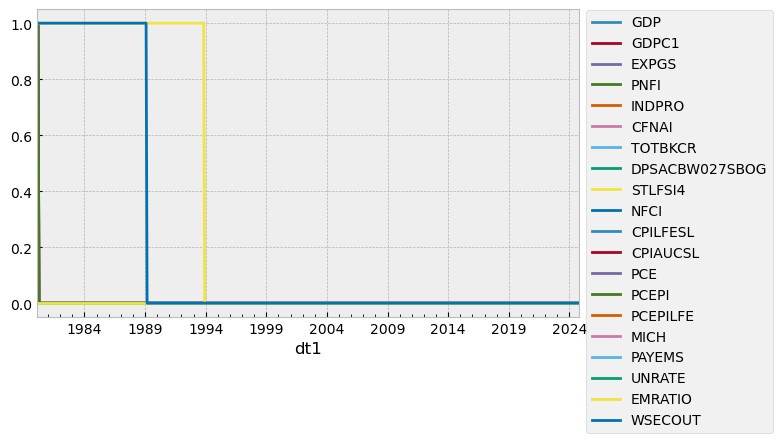

In [28]:
_ = df.set_index('dt1').isnull().astype(int).plot(figsize = (7,4))
_ = _.legend(bbox_to_anchor=(1., 1.02))

In [32]:
MIN_DATE = '1994-12-01'
df[df.dt1 > MIN_DATE].isnull().sum()

dt1               0
GDP               0
GDPC1             0
EXPGS             0
PNFI              0
INDPRO            0
CFNAI             0
TOTBKCR           0
DPSACBW027SBOG    0
STLFSI4           0
NFCI              0
CPILFESL          0
CPIAUCSL          0
PCE               0
PCEPI             0
PCEPILFE          0
MICH              0
PAYEMS            0
UNRATE            0
EMRATIO           0
WSECOUT           0
dtype: int64